In [5]:
import numpy as np
import os
from torch.utils.data import DataLoader
import torch
from vit_pytorch import ViT
from vit_pytorch.cct import CCT
from scripts.model import *
from vit_pytorch.recorder import Recorder
from vit_pytorch.extractor import Extractor
from skimage.transform import resize

In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import v2
import torch

preprocess = v2.Compose([
    v2.Resize(128),
    # transforms.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# preprocess = v2.Compose([
#     v2.RandomResizedCrop(128, scale=(0.8, 1.0)),
#     v2.RandomHorizontalFlip(),
#     v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     v2.RandomRotation(degrees=15),
#     v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# note for self, no idea what these normalize transforms do, but oh well

class ImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, set_type, transform=preprocess, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_labels = self.img_labels[self.img_labels['set_type'] == set_type].reset_index(drop=True)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
        
    return image, label

In [6]:
img_dir = 'linsen_data'
annotations_file = 'linsen_data/annotations.csv'

BATCH_SIZE = 32
num_epochs = 10

ds_train = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='train')
ds_test = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='test')

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
with open('models/cct/model/model_config.json') as json_file:
  model_config = json.load(json_file)

model = CCT(
  img_size = tuple(model_config['img_size']),
  embedding_dim = model_config['embedding_dim'],
  n_conv_layers = model_config['n_conv_layers'],
  kernel_size = model_config['kernel_size'],
  stride = model_config['stride'],
  padding = model_config['padding'],
  pooling_kernel_size = model_config['pooling_kernel_size'],
  pooling_stride = model_config['pooling_stride'],
  pooling_padding = model_config['pooling_padding'],
  num_layers = model_config['num_layers'],
  num_heads = model_config['num_heads'],
  mlp_ratio = model_config['mlp_ratio'],
  num_classes = model_config['num_classes'],
  positional_embedding = model_config['positional_embedding']
)

model.load_state_dict(torch.load('models/cct/model/model.pth', weights_only=True))
        
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

154083


In [8]:
print(model_config)

{'img_size': [128, 128], 'embedding_dim': 32, 'n_conv_layers': 2, 'kernel_size': 7, 'stride': 2, 'padding': 3, 'pooling_kernel_size': 3, 'pooling_stride': 2, 'pooling_padding': 1, 'num_layers': 4, 'num_heads': 4, 'mlp_ratio': 3.0, 'num_classes': 2, 'positional_embedding': 'learnable'}


In [9]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output  

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  

    def generate_heatmap(self, input_image, target_spatial_position):
        output = self.model(input_image)

        x, y = target_spatial_position
        target_score = output[0, :, x, y].sum()  

        self.model.zero_grad()
        target_score.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        heatmap = torch.sum(weights * activations, dim=1).squeeze()

        heatmap = F.relu(heatmap)
        heatmap = - heatmap / torch.max(heatmap) 

        return heatmap.detach().cpu().numpy()

    def overlay_heatmap(self, heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
        overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
        return overlayed_image


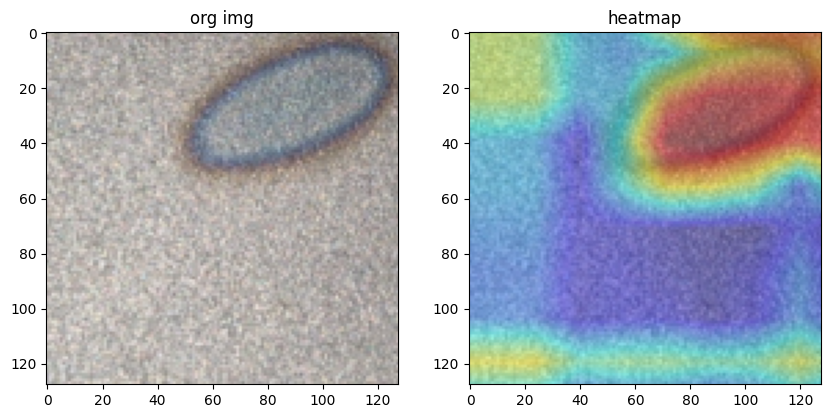

In [12]:
img_idx = 0
image_tensor = ds_test[img_idx][0].unsqueeze(0) 
target_class = ds_test[img_idx][1] 

def get_features(model, x, target_layer):
    for layer in model.tokenizer.conv_layers:
        x = layer(x)
        if layer == target_layer:
            break
    return x

processed_features = get_features(model, image_tensor, model.tokenizer.conv_layers[-1])
_, _, height, width = processed_features.shape 

combined_heatmap = np.zeros((height, width))

grad_cam = GradCAM(model.tokenizer.conv_layers, target_layer=model.tokenizer.conv_layers[-1])

for x in range(height):
    for y in range(width):
        heatmap = grad_cam.generate_heatmap(image_tensor, target_spatial_position=(x, y))
        combined_heatmap += heatmap  

combined_heatmap -= combined_heatmap.min()
combined_heatmap /= combined_heatmap.max()

from skimage.transform import resize
input_image = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
input_image = (input_image * 255).astype(np.uint8)

resized_heatmap = resize(combined_heatmap, input_image.shape[:2], mode='reflect')

overlayed_image = grad_cam.overlay_heatmap(resized_heatmap, input_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("org img")
plt.imshow(input_image)

plt.subplot(1, 2, 2)
plt.title("heatmap")
plt.imshow(overlayed_image)
plt.show()


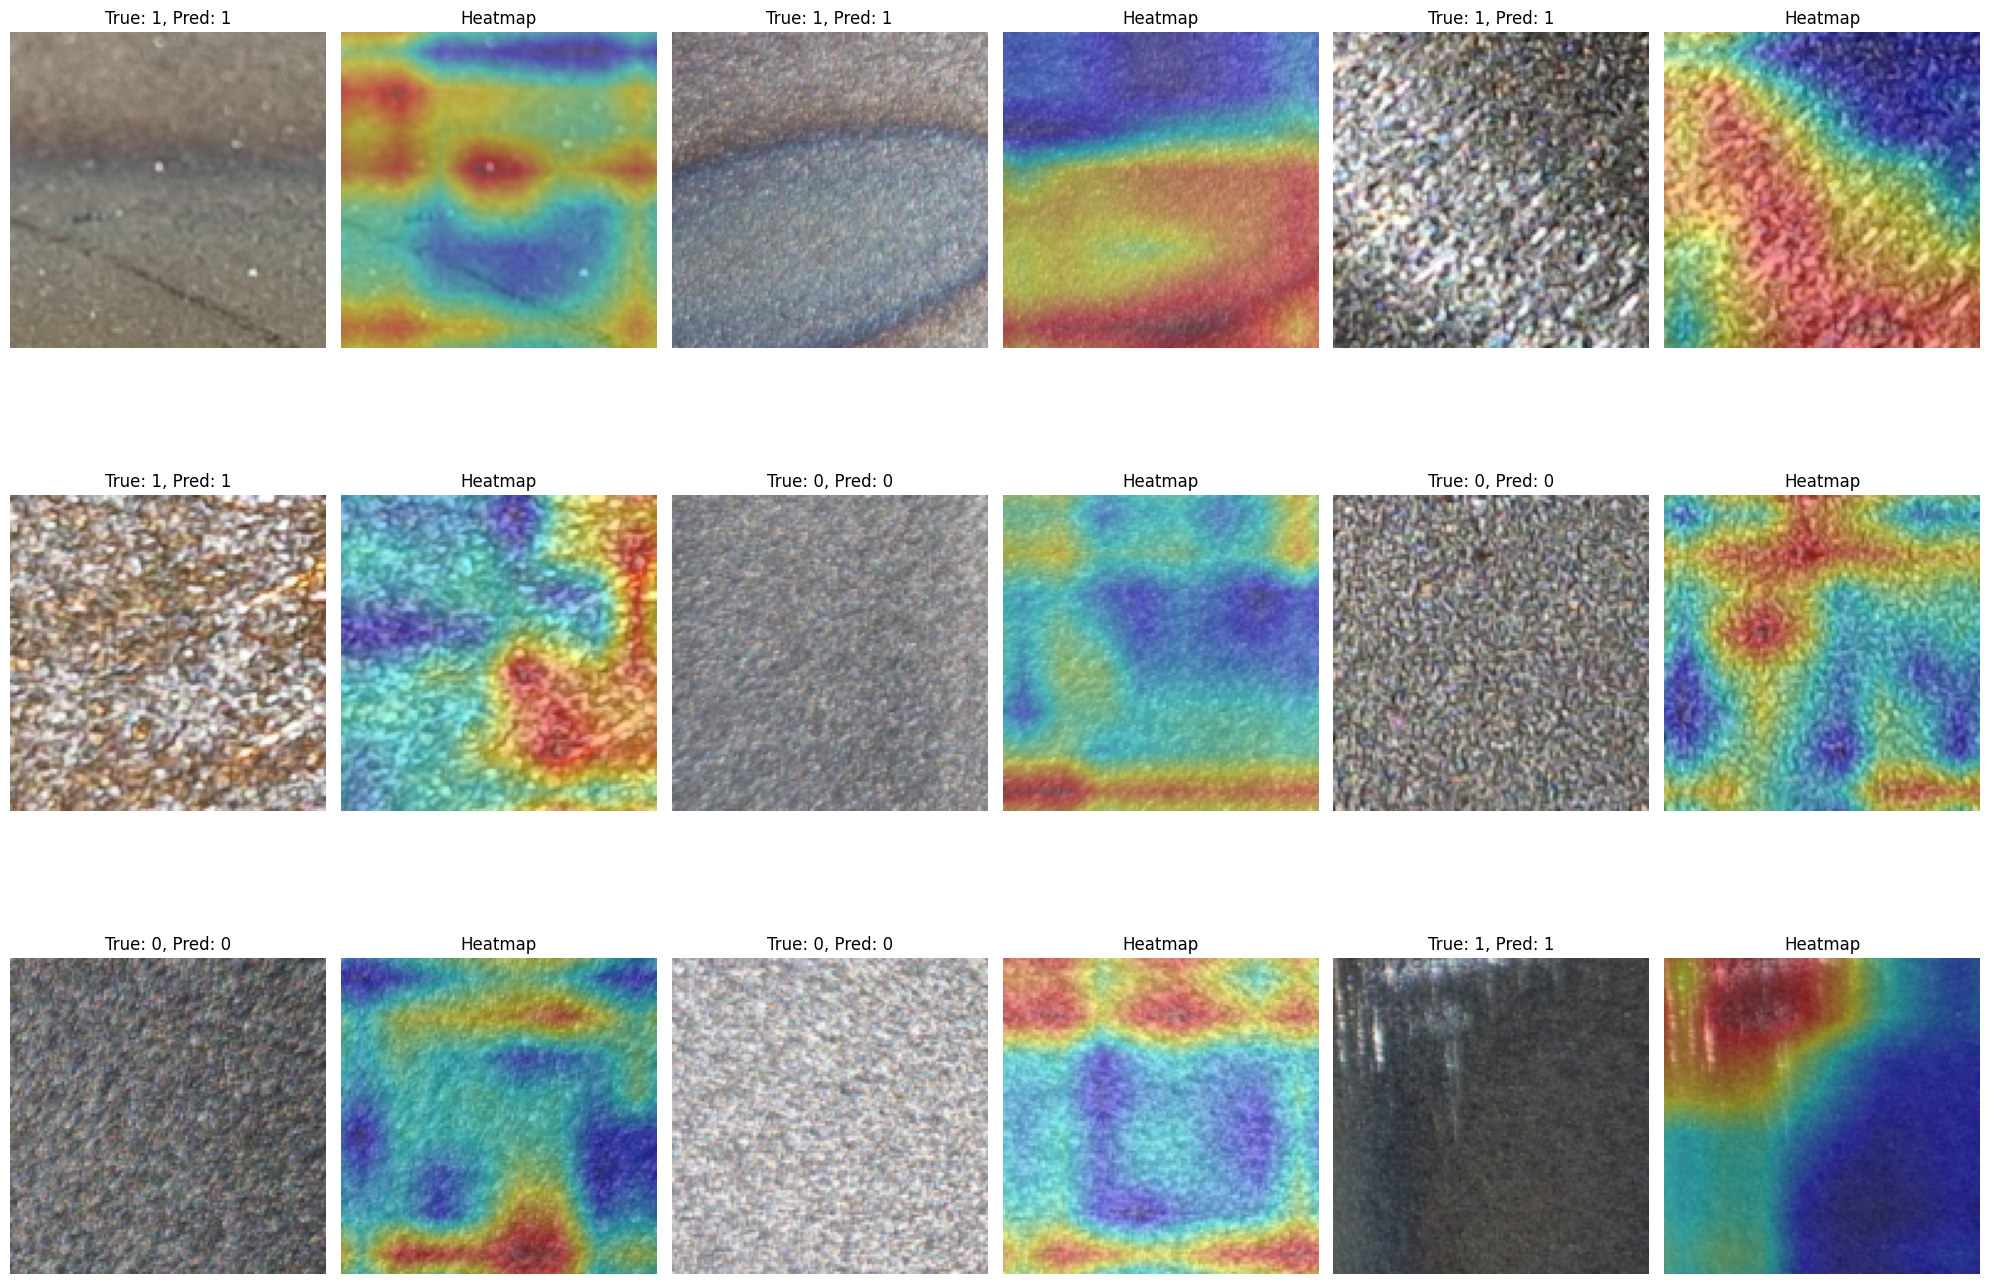

In [11]:
import random
from skimage.transform import resize
import matplotlib.pyplot as plt

grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size * 2, figsize=(20, 15))

random_indices = random.sample(range(len(ds_test)), grid_size * grid_size)

grad_cam = GradCAM(model.tokenizer.conv_layers, target_layer=model.tokenizer.conv_layers[-1])

for idx, img_idx in enumerate(random_indices):
    image_tensor = ds_test[img_idx][0].unsqueeze(0)
    target_class = ds_test[img_idx][1]

    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor).argmax(dim=1).item()

    combined_heatmap = np.zeros((height, width))

    for x in range(height):
        for y in range(width):
            heatmap = grad_cam.generate_heatmap(image_tensor, target_spatial_position=(x, y))
            combined_heatmap += heatmap

    combined_heatmap -= combined_heatmap.min()
    combined_heatmap /= combined_heatmap.max()

    input_image = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    input_image = (input_image * 255).astype(np.uint8)
    resized_heatmap = resize(combined_heatmap, input_image.shape[:2], mode='reflect')

    overlayed_image = grad_cam.overlay_heatmap(resized_heatmap, input_image)

    row = idx // grid_size
    col = idx % grid_size

    axes[row, col * 2].imshow(input_image)
    axes[row, col * 2].axis("off")
    axes[row, col * 2].set_title(f"True: {target_class}, Pred: {prediction}")

    axes[row, col * 2 + 1].imshow(overlayed_image)
    axes[row, col * 2 + 1].axis("off")
    axes[row, col * 2 + 1].set_title("Heatmap")

plt.tight_layout()
plt.show()



In [17]:
import torch
from torch.utils.data import DataLoader

def calculate_accuracy(model, dataset, batch_size=1):
    model.eval()
    correct = 0
    total = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

accuracy = calculate_accuracy(model, ds_test)
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 93.85%


In [10]:
from sklearn.metrics import classification_report

def calculate_classrep(model, dataset, batch_size=1):
    model.eval()
    correct = 0
    total = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    y_preds = []
    y_trues = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_preds.append(np.array(predicted))
            y_trues.append(np.array(labels))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(y_trues)
    
    print(classification_report(np.array(y_trues), np.array(y_preds)))

    accuracy = (correct / total) * 100
    return accuracy

In [11]:
import torch
print(torch.__version__)

2.3.0+cpu


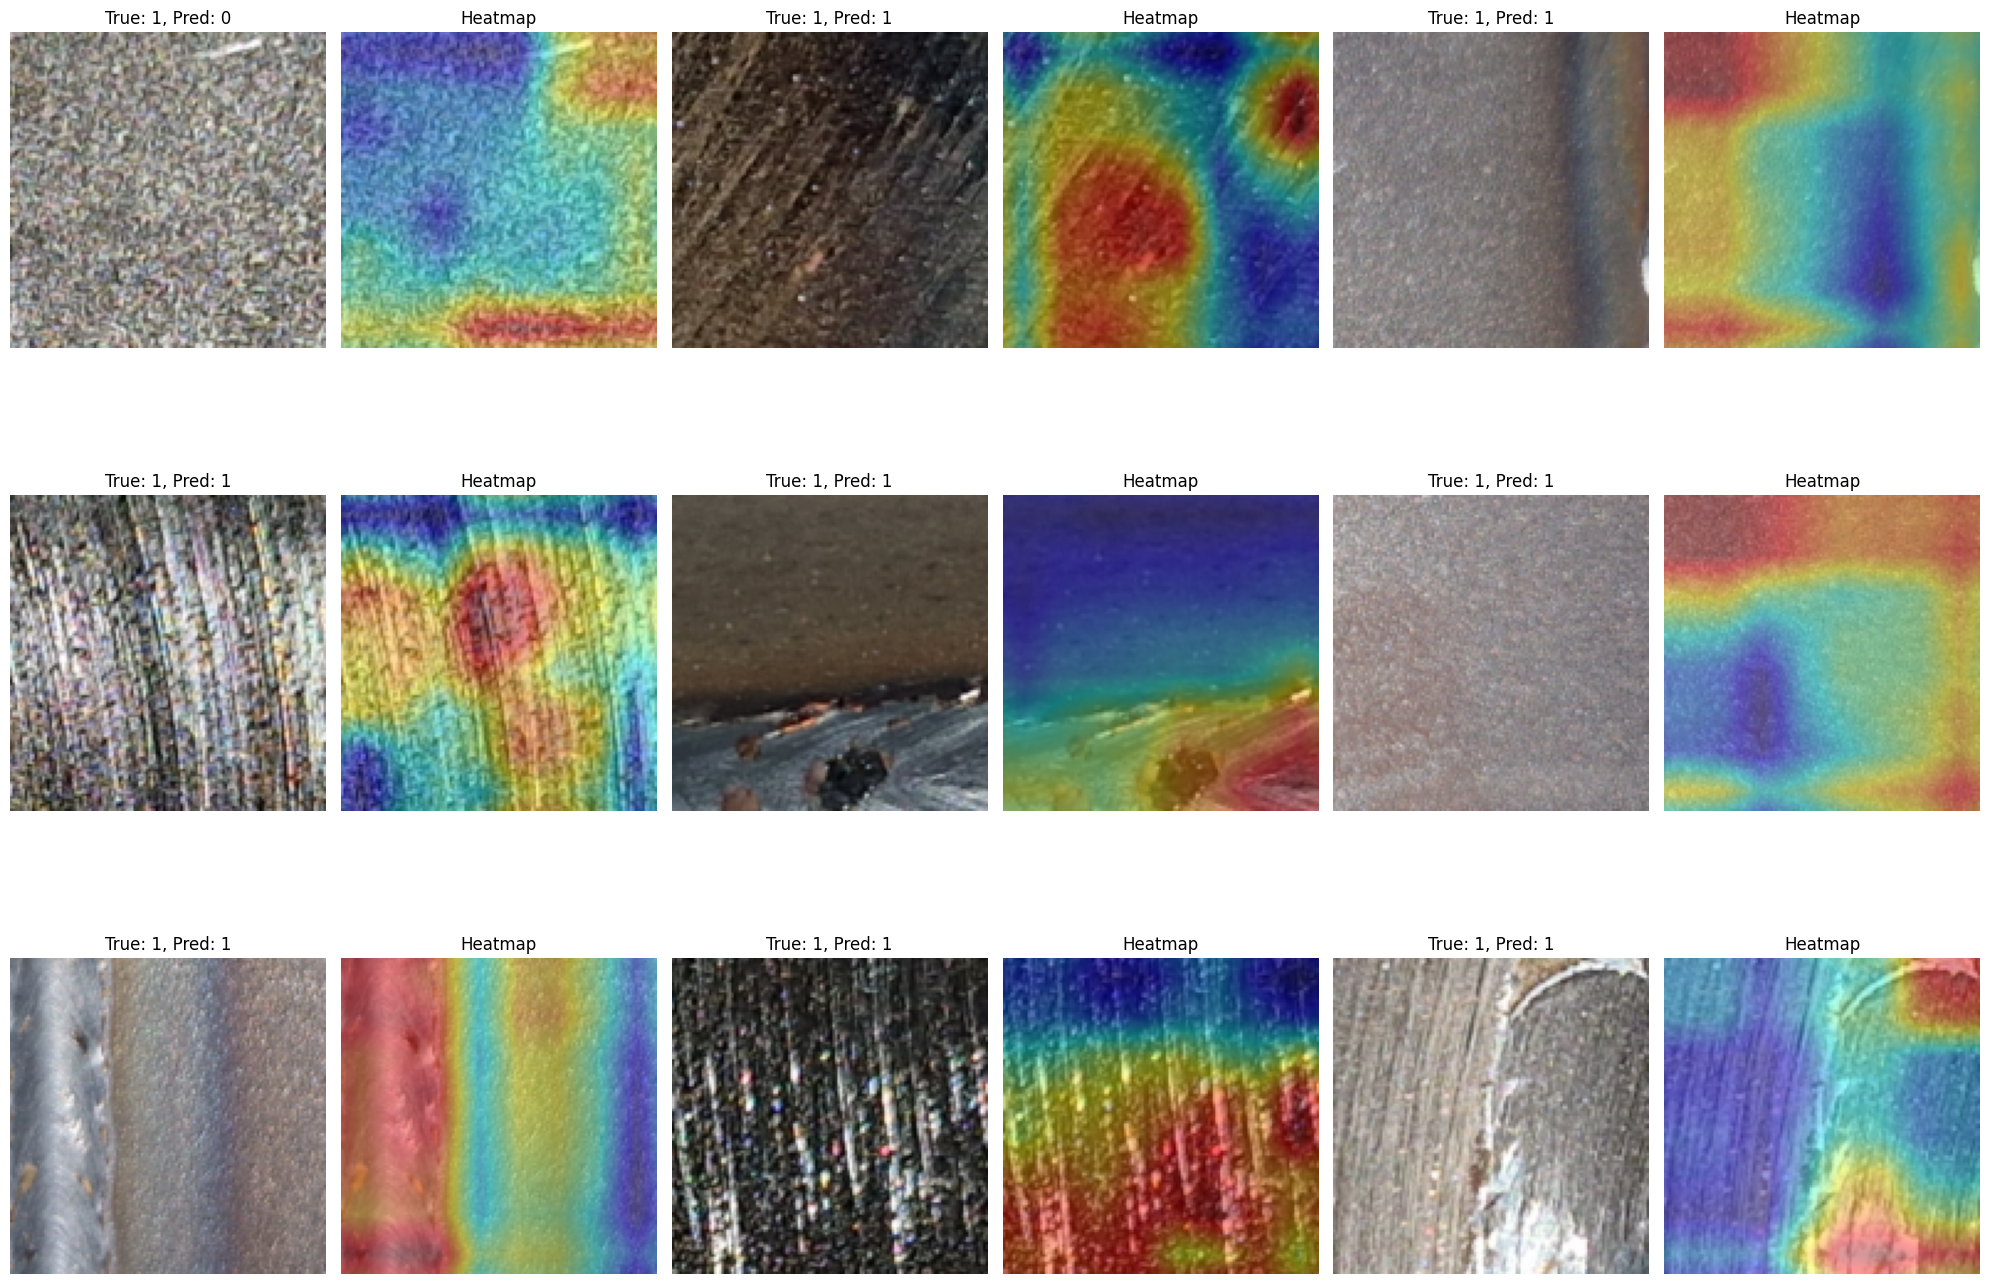

In [21]:
import random
from skimage.transform import resize
import matplotlib.pyplot as plt

grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size * 2, figsize=(20, 15))

class_0_indices = [i for i in range(len(ds_test)) if ds_test[i][1] == 1]
random_indices = random.sample(class_0_indices, grid_size * grid_size)

grad_cam = GradCAM(model.tokenizer.conv_layers, target_layer=model.tokenizer.conv_layers[-1])

for idx, img_idx in enumerate(random_indices):
    image_tensor = ds_test[img_idx][0].unsqueeze(0)
    target_class = ds_test[img_idx][1]

    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor).argmax(dim=1).item()

    combined_heatmap = np.zeros((height, width))

    for x in range(height):
        for y in range(width):
            heatmap = grad_cam.generate_heatmap(image_tensor, target_spatial_position=(x, y))
            combined_heatmap += heatmap

    combined_heatmap -= combined_heatmap.min()
    combined_heatmap /= combined_heatmap.max()

    input_image = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    input_image = (input_image * 255).astype(np.uint8)
    resized_heatmap = resize(combined_heatmap, input_image.shape[:2], mode='reflect')

    overlayed_image = grad_cam.overlay_heatmap(resized_heatmap, input_image)

    row = idx // grid_size
    col = idx % grid_size

    axes[row, col * 2].imshow(input_image)
    axes[row, col * 2].axis("off")
    axes[row, col * 2].set_title(f"True: {target_class}, Pred: {prediction}")

    axes[row, col * 2 + 1].imshow(overlayed_image)
    axes[row, col * 2 + 1].axis("off")
    axes[row, col * 2 + 1].set_title("Heatmap")

plt.tight_layout()
plt.show()
